In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

import queue
from typing import Any, Optional, List
import asyncio
import nest_asyncio
nest_asyncio.apply()

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext
from qubx.impl.ccxt_connector import CCXTConnector
from qubx.utils.runner import get_account_config
from qubx.pandaz import scols


# path to pythonpath /mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments
sys.path.append('/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments')


def clear_queue(q: queue.Queue):
    while not q.empty():
        try:
            q.get_nowait()
        except queue.Empty:
            continue


 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. 0.1.90
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
from pathlib import Path
from strats.teststrat import FlipFlopStrat

CONFIG_PATH = Path("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments/configs")

auth = get_account_config(
    "binance-mde", str(CONFIG_PATH / ".env.fishermen2")
)

In [11]:
# it requires passing the commission because it can't find it otherwise in the info
cc = CCXTConnector("binance.um", **auth, commissions="vip0_usdt")  # type: ignore

symbols = ["LINK", "XRP"]
instruments = [lookup.find_instrument("BINANCE.UM", s, "USDT") for s in symbols]

2024-07-19 10:24:12.478 [ ℹ️ ] BINANCEUSDM loading ...


2024-07-19 10:24:14.366 [ ℹ️ ] Loading account data for Binance USDⓈ-M
2024-07-19 10:24:14.693 [ ℹ️ ] BINANCE USDⓈ-M initialized - current time 2024-07-19T10:24:14.693643000


In [ ]:

channel = cc.get_communication_channel()
if not channel.control.is_set():
    channel.start()

ctx = StrategyContext(
    FlipFlopStrat(),
    dict(capital_invested=50, trading_allowed=True),
    cc,
    cc,
    instruments=instruments,  # type: ignore
    md_subscription=dict(type="ohlc", timeframe="1Min", nback=100),
    trigger_spec="1Min -5s",
)
S = ctx.strategy

try:
    ctx.start(blocking=True)
except KeyboardInterrupt:
    logger.info("Stopped by user")
finally:
    ctx.stop()
    channel.stop()
    clear_queue(channel.queue)

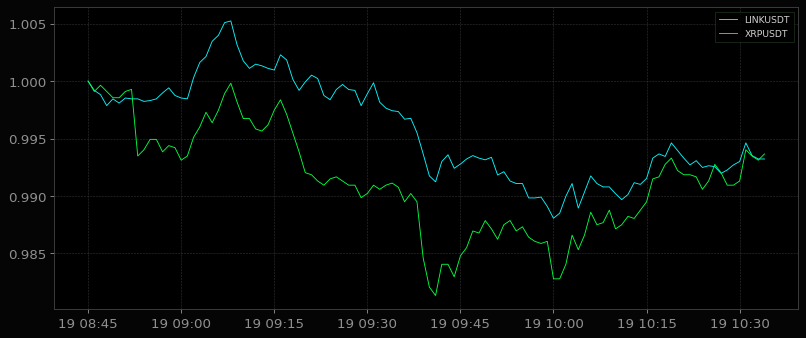

In [14]:
N = lambda x: x / x.iloc[0]
for s, hh in S.ohlcs('1min').items():
    plt.plot(N(hh.close), label=s)
plt.legend();